# Anomoly Detection 
As an example, 100 samples are generated from a normal distribution with a mean of 10 and standard deviation of two. Then, three outliers are added manually (15, 20, 25).

The probability of observing a value less than or equal to 15 is 0.9937903346742238
The probability of observing a value less than or equal to 20 is 0.9999997133484281
The probability of observing a value less than or equal to 25 is 0.9999999999999681


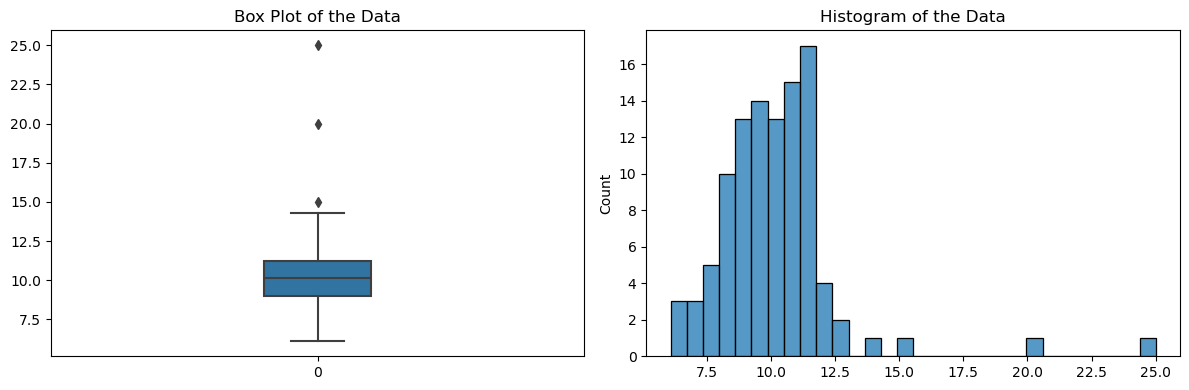

In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(seed=42)

mean = 10
std_dev = 2
outliers = [15, 20, 25]
for observation in outliers:
    z = (observation - mean) / std_dev # Find z-score
    probability = stats.norm.cdf(z)
    print(f"The probability of observing a value less than or equal to {observation} is {probability}")
    
x = np.append(rng.normal(mean, std_dev, 100), outliers)
df = pd.DataFrame({'x': x})

fig, axs = plt.subplots(1, 2)
sns.boxplot(x, width=.2, ax=axs[0])
axs[0].set_title('Box Plot of the Data')
sns.histplot(x, bins=30, kde=False, ax=axs[1])
axs[1].set_title('Histogram of the Data')
plt.tight_layout()
plt.show()

## Interquartile Range (IQR)
For outlier detection, a good rule of thumb is to investigate points that fall outside of $Q1 - 1.5 * IQR$ or $Q3 + 1.5 * IQR$.

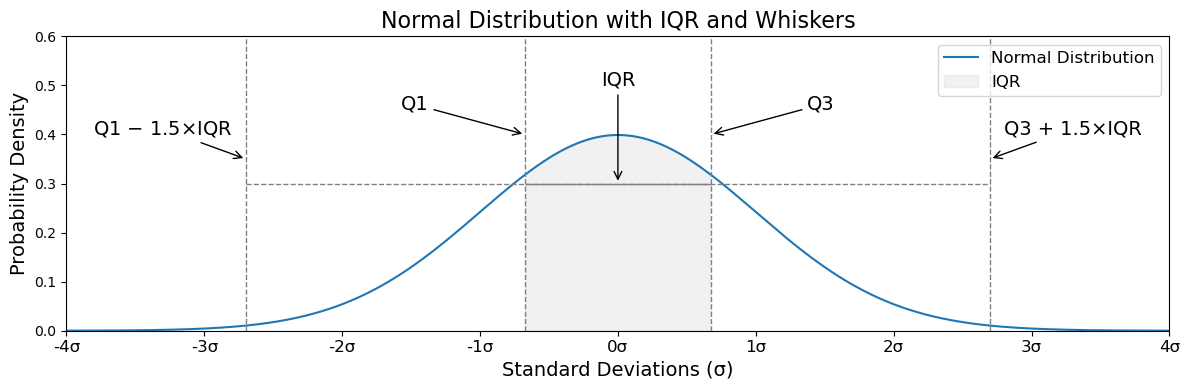

In [180]:
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x, 0, 1)
Q1 = -0.6745
Q3 = 0.6745
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

fig, ax = plt.subplots()
ax.plot(x, y, color='tab:blue', label='Normal Distribution')
ax.fill_between(x, 0, y, where=(x >= Q1) & (x <= Q3), color='lightgrey', alpha=0.3, label='IQR')

ax.annotate('IQR', xy=(0, 0.3), xytext=(0, 0.5), color='black', fontsize=14,
            ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q1', xy=(Q1, 0.4), xytext=(Q1 - 0.8, 0.45), color='black', fontsize=14,
            ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q3', xy=(Q3, 0.4), xytext=(Q3 + 0.8, 0.45), color='black', fontsize=14,
            ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q1 $-$ 1.5×IQR', xy=(lower_whisker, 0.35), xytext=(lower_whisker - 0.6, 0.4),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q3 + 1.5×IQR', xy=(upper_whisker, 0.35), xytext=(upper_whisker + 0.6, 0.4),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))

# Vertical lines
ax.axvline(Q1, color='grey', linestyle='--', linewidth=1)
ax.axvline(Q3, color='grey', linestyle='--', linewidth=1)
ax.axvline(lower_whisker, color='grey', linestyle='--', linewidth=1)
ax.axvline(upper_whisker, color='grey', linestyle='--', linewidth=1)

# Horizontal lines for IQR and whiskers
ax.hlines(y=0.3, xmin=Q1, xmax=Q3, color='grey', linewidth=1)
ax.hlines(y=0.3, xmin=lower_whisker, xmax=upper_whisker, color='grey', linestyle='--', linewidth=1)

# Set x-limits and ticks
ax.set_xlim([-4, 4])
ax.set_ylim([0, 0.6])
ax.set_xticks(np.arange(-4, 5, 1))
ax.set_xticklabels([f'{i}σ' for i in range(-4, 5)], fontsize=12)
ax.set_xlabel('Standard Deviations (σ)', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.set_title('Normal Distribution with IQR and Whiskers', fontsize=16)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In skewed distributions, the data may have extreme values or outliers in the direction of the skew. The presence of skewness might lead to misclassifying values near the tails as outliers or failing to detect true outliers.

Alternatives such as the **median absolute deviation (MAD)** or **transformations** (e.g., log transformation) may help better capture the variability and deal with the effects of skewness.

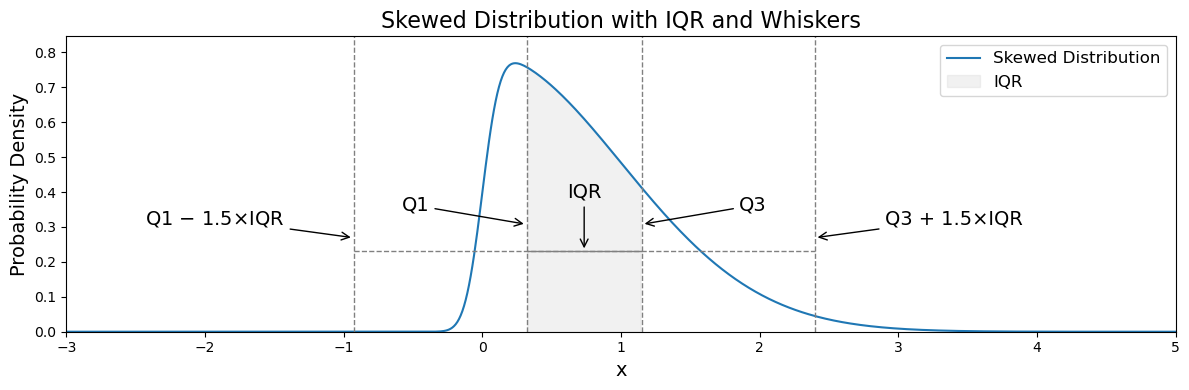

In [187]:
# Parameters for the skew-normal distribution
a = 10  # Skewness parameter (positive for right skew)
loc = 0  # Location parameter (mean)
scale = 1  # Scale parameter (standard deviation)

x = np.linspace(-4, 8, 1000)
y = stats.skewnorm.pdf(x, a, loc, scale)
Q1 = stats.skewnorm.ppf(0.25, a, loc, scale)
Q3 = stats.skewnorm.ppf(0.75, a, loc, scale)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

fig, ax = plt.subplots()
ax.plot(x, y, color='tab:blue', label='Skewed Distribution')
ax.fill_between(x, 0, y, where=(x >= Q1) & (x <= Q3), color='lightgrey', alpha=0.3, label='IQR')

ax.annotate('IQR', xy=((Q1 + Q3) / 2, 0.3 * y.max()), xytext=((Q1 + Q3) / 2, 0.5 * y.max()),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q1', xy=(Q1, 0.4 * y.max()), xytext=(Q1 - 0.8, 0.45 * y.max()),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q3', xy=(Q3, 0.4 * y.max()), xytext=(Q3 + 0.8, 0.45 * y.max()),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q1 $-$ 1.5×IQR', xy=(lower_whisker, 0.35 * y.max()), xytext=(lower_whisker - 1, 0.4 * y.max()),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))
ax.annotate('Q3 + 1.5×IQR', xy=(upper_whisker, 0.35 * y.max()), xytext=(upper_whisker + 1, 0.4 * y.max()),
            color='black', fontsize=14, ha='center', arrowprops=dict(arrowstyle='->'))

# Vertical lines
ax.axvline(Q1, color='grey', linestyle='--', linewidth=1)
ax.axvline(Q3, color='grey', linestyle='--', linewidth=1)
ax.axvline(lower_whisker, color='grey', linestyle='--', linewidth=1)
ax.axvline(upper_whisker, color='grey', linestyle='--', linewidth=1)

# Horizontal lines for IQR and whiskers
ax.hlines(y=0.3 * y.max(), xmin=Q1, xmax=Q3, color='grey', linewidth=1)
ax.hlines(y=0.3 * y.max(), xmin=lower_whisker, xmax=upper_whisker, color='grey', linestyle='--', linewidth=1)

# Set x-limits and ticks
ax.set_xlim([-3, 5])
ax.set_ylim([0, 1.1 * y.max()])
ax.set_xticks(np.arange(-3, 6, 1))
ax.set_xlabel('x', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.set_title('Skewed Distribution with IQR and Whiskers', fontsize=16)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
Q1 = df['x'].quantile(0.25) # 25th percentile
Q3 = df['x'].quantile(0.75) # 75th percentile
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower bound: {lower_bound:0.2f}")
print(f"Upper bound: {upper_bound:0.2f}")

outliers = df[(df['x'] < lower_bound) | (df['x'] > upper_bound)]
outliers[['x']].rename(columns={'x': 'outliers'})


Lower bound: 5.74
Upper bound: 14.48


,outliers
100,15.0
101,20.0
102,25.0


## Z-Score
A common threshold for identifying outliers is a Z-score greater than 3 or less than -3.

In [39]:
df['z_score'] = stats.zscore(df['x'])
df[abs(df.z_score) >= 3]

,x,z_score
101,20.0,4.111188
102,25.0,6.207376


## DBSCAN Clustering
cluster = -1 are considered outliers by DBSCAN

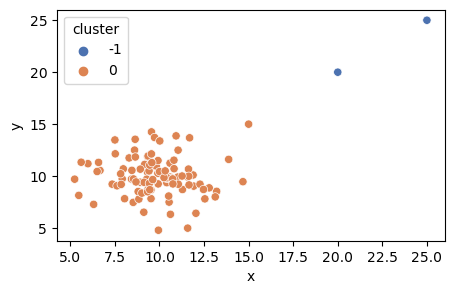

In [201]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['x','y']])

dbscan = DBSCAN(eps=1.5, min_samples=2)
df['cluster'] = dbscan.fit_predict(df_scaled)

plt.figure(figsize=(5, 3))
sns.scatterplot(x='x', y='y', data=df, hue='cluster', palette="deep")
plt.show()

## Isolation Forest <a name="Isolation-Forest"></a> 

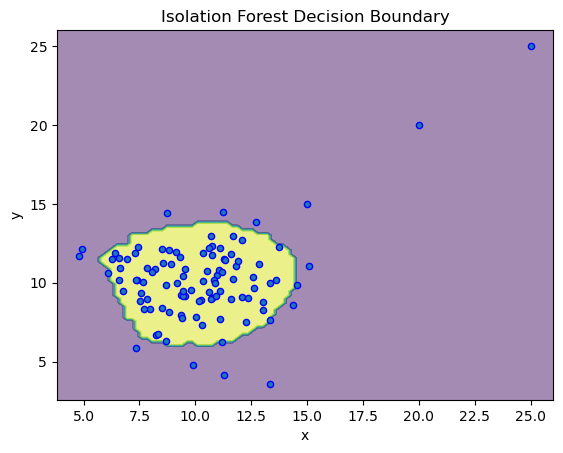

In [117]:
clf = IsolationForest(random_state=42).fit(df[['x','y']])
# clf.predict(df[['x','y']])

disp = DecisionBoundaryDisplay.from_estimator(clf, df[['x','y']], response_method="predict", alpha=0.5)
disp.ax_.scatter(df['x'], df['y'], s=20, edgecolor="b")
disp.ax_.set_title("Isolation Forest Decision Boundary")
plt.show()

## Local Outlier Factor (LOF)
* [scikit-learn API](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)
* [Outlier detection with Local Outlier Factor (LOF)](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html)

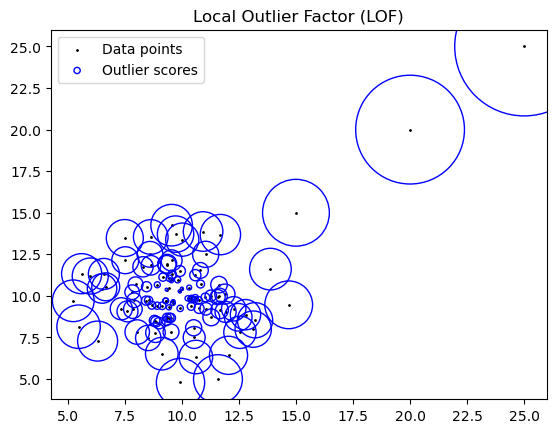

In [200]:
from sklearn.neighbors import LocalOutlierFactor
from matplotlib.legend_handler import HandlerPathCollection

clf = LocalOutlierFactor(n_neighbors=50)
y_pred = clf.fit_predict(df[['x','y']])
X_scores = clf.negative_outlier_factor_

def update_legend_marker_size(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([20])

plt.scatter(df['x'], df['y'], color="k", s=1, label="Data points")
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(df['x'], df['y'], s=10000 * radius, edgecolors="b", facecolors="none", label="Outlier scores")
plt.legend(handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)})
plt.title("Local Outlier Factor (LOF)")
plt.show()


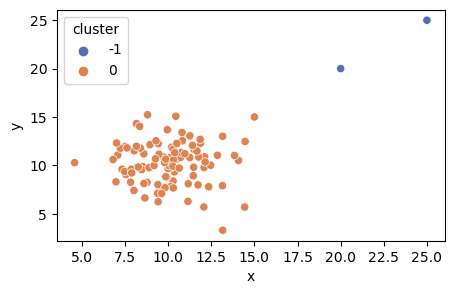

## References
- [The UCR Matrix Profile Page](https://www.cs.ucr.edu/~eamonn/MatrixProfile.html)
- [Matrix Profile Example](https://github.com/matrix-profile-foundation/article-matrix-profile-intro/blob/master/Matrix%20Profile%20Example.ipynb)